In [2]:
import scanpy as sc
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import gc
import pickle
import glob
import scipy.stats

In [3]:
import gseapy as gp

In [5]:
from scooby.utils.plotting import plot_cells_pseudotime

In [6]:
data_path = 'tmp'

In [7]:
adata = sc.read(os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed_GEX.h5ad'))

In [8]:
ad_outputs = sc.read(os.path.join(data_path, 'eval_fixed/test_val_genes.h5ad'))
ad_outputs.uns['l2_cell_type_colors'] = adata.uns['l2_cell_type_colors']
sc.pp.normalize_total(ad_outputs)

## Plot lineages

In [9]:
ct_colors = pd.Series(adata.uns['l2_cell_type_colors'], 
                     index=adata.obs['l2_cell_type'].values.categories)

In [34]:
# Lineage cells 
meta_lineage_cells = pd.Series(dtype=object)
# Erytrocyte lineage
meta_lineage_cells['Erythroblast'] = adata.obs_names[adata.obs['l2_cell_type'].isin(
    ['MK/E prog', 'HSC', 'Proerythroblast', 'Erythroblast', 'Normoblast'])]

# Monocyte lineage
meta_lineage_cells['Monocytes'] = adata.obs_names[adata.obs['l2_cell_type'].isin(
    ['G/M prog', 'HSC', 'CD14+ Mono', 'CD16+ Mono'])]

meta_lineage_cells['B'] = adata.obs_names[adata.obs['l2_cell_type'].isin(
    ['Early Lymphoid', 'HSC', 'Transitional B', 'B1 B', 'Naive CD20+ B'])]

## Plot pseudotime deletion

In [11]:
motif_path = os.path.join(data_path, 'motif_deletion/')

In [38]:
ad_alt = dict()
ad_ref = sc.read(os.path.join(motif_path, 'ref_multiome_fixed.h5ad'))

In [39]:
ad_alt['GATA1'] = sc.read(os.path.join(motif_path, 'alt_GATA1.H12CORE.1.PSM.A_multiome_fixed.h5ad'))
ad_alt['EBF1'] = sc.read(os.path.join(motif_path, 'alt_COE1.H12CORE.0.P.B_multiome_fixed.h5ad'))

Only considering the two last: ['.A_multiome_fixed', '.h5ad'].
Only considering the two last: ['.A_multiome_fixed', '.h5ad'].
Only considering the two last: ['.B_multiome_fixed', '.h5ad'].
Only considering the two last: ['.B_multiome_fixed', '.h5ad'].


In [40]:
for tf, ad in ad_alt.items():
    ad_alt[tf].obs['dpt_pseudotime'] = adata.obs['dpt_pseudotime']
    ad_alt[tf].uns['l2_cell_type_colors'] = adata.uns['l2_cell_type_colors']
    ad_alt[tf].obs['rna_difference'] = (np.log2(ad_ref.X+1) - np.log2(ad.X +1)).mean(axis = 1)
    ad_alt[tf].obs['atac_difference'] =  (np.log2(ad_ref.layers['atac']+1) - np.log2(ad.layers['atac'] +1)).mean(axis = 1)

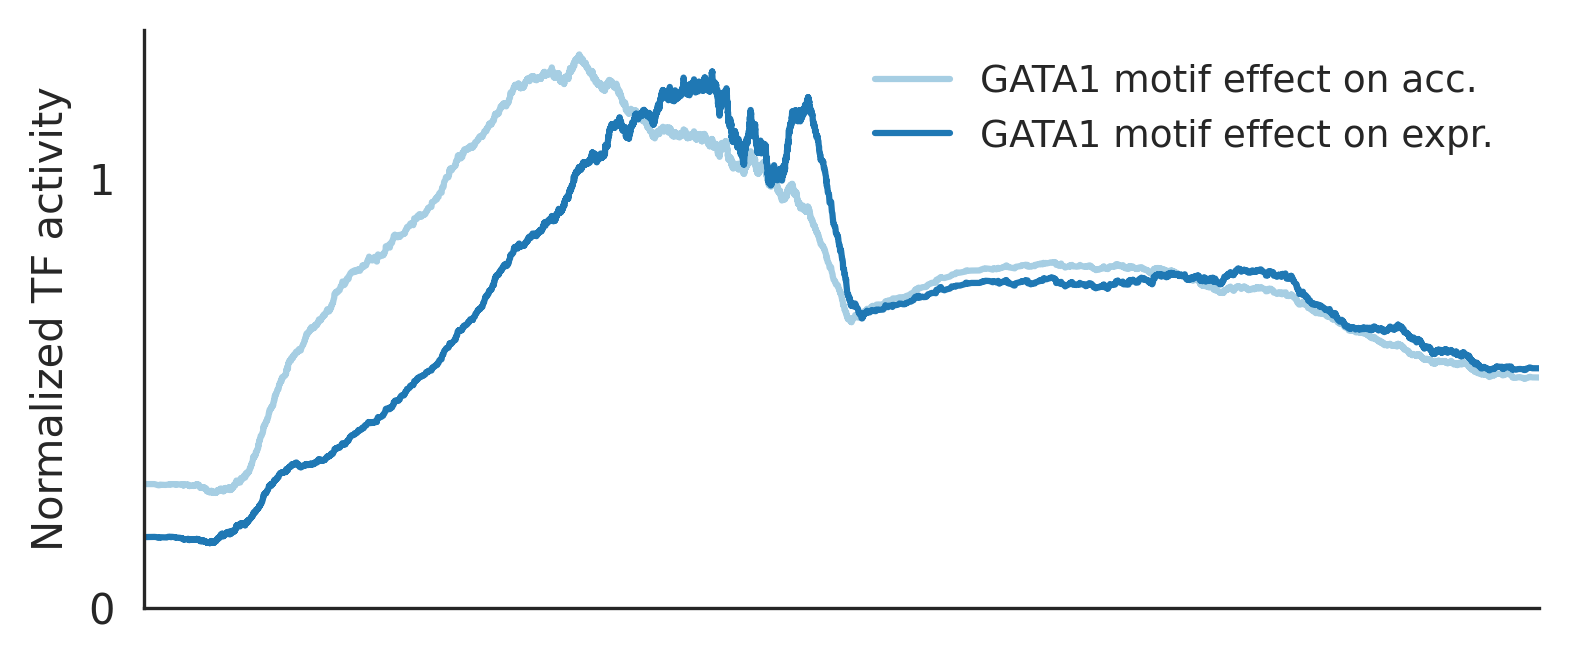

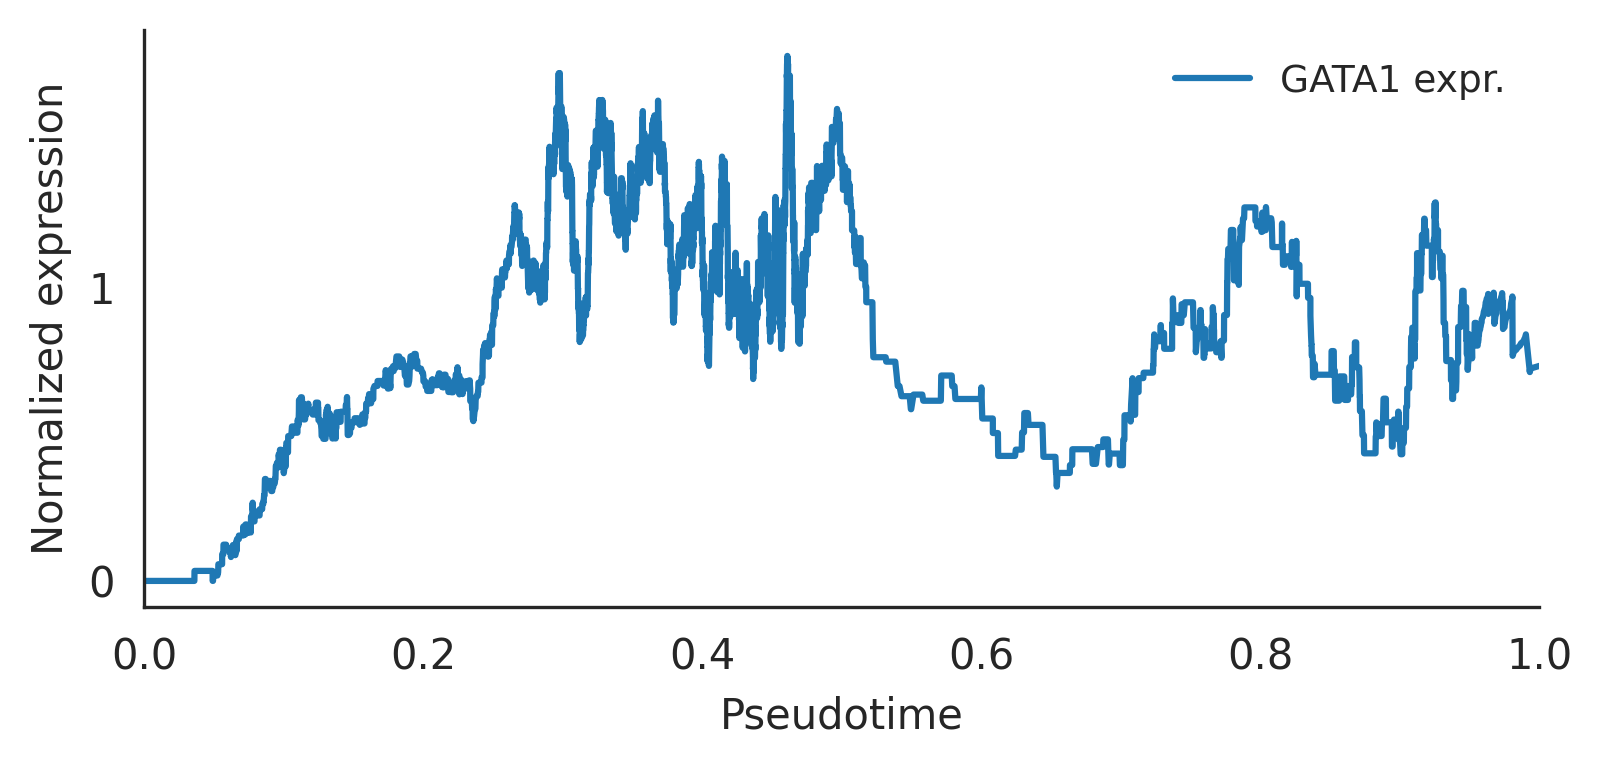

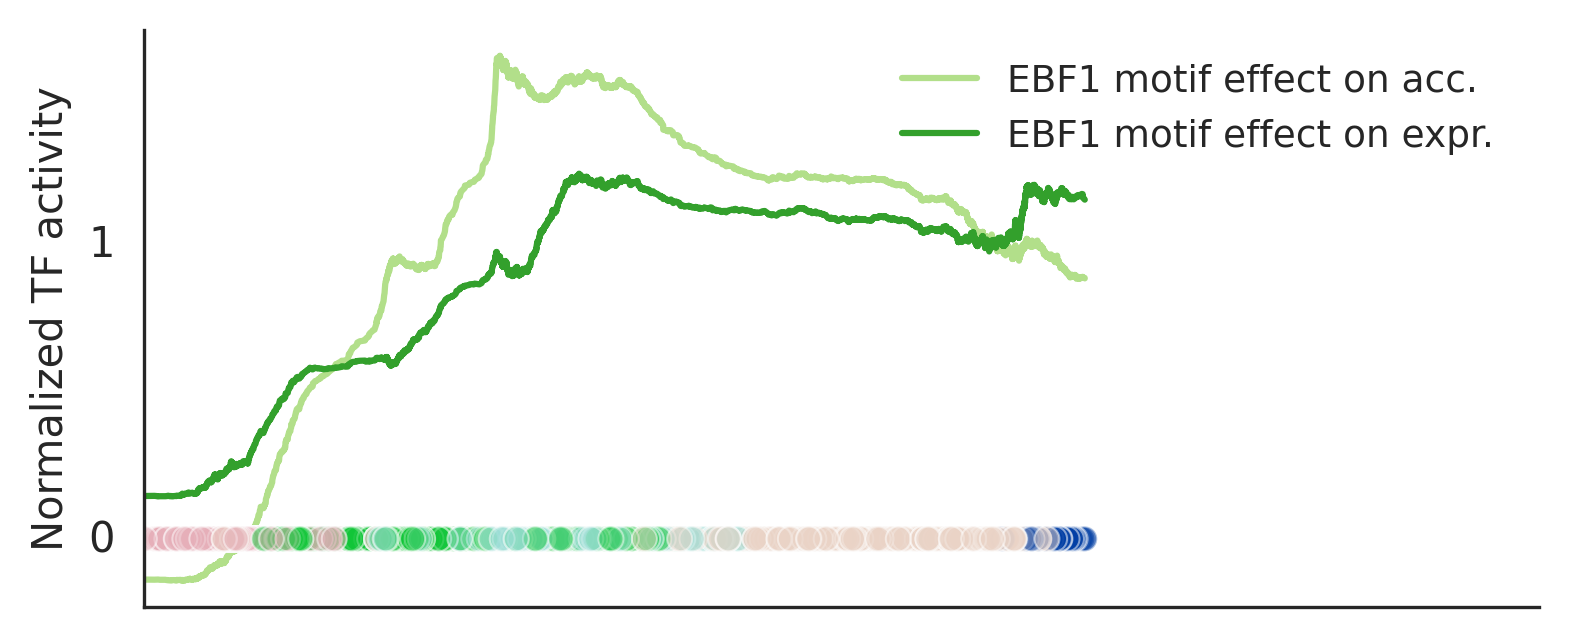

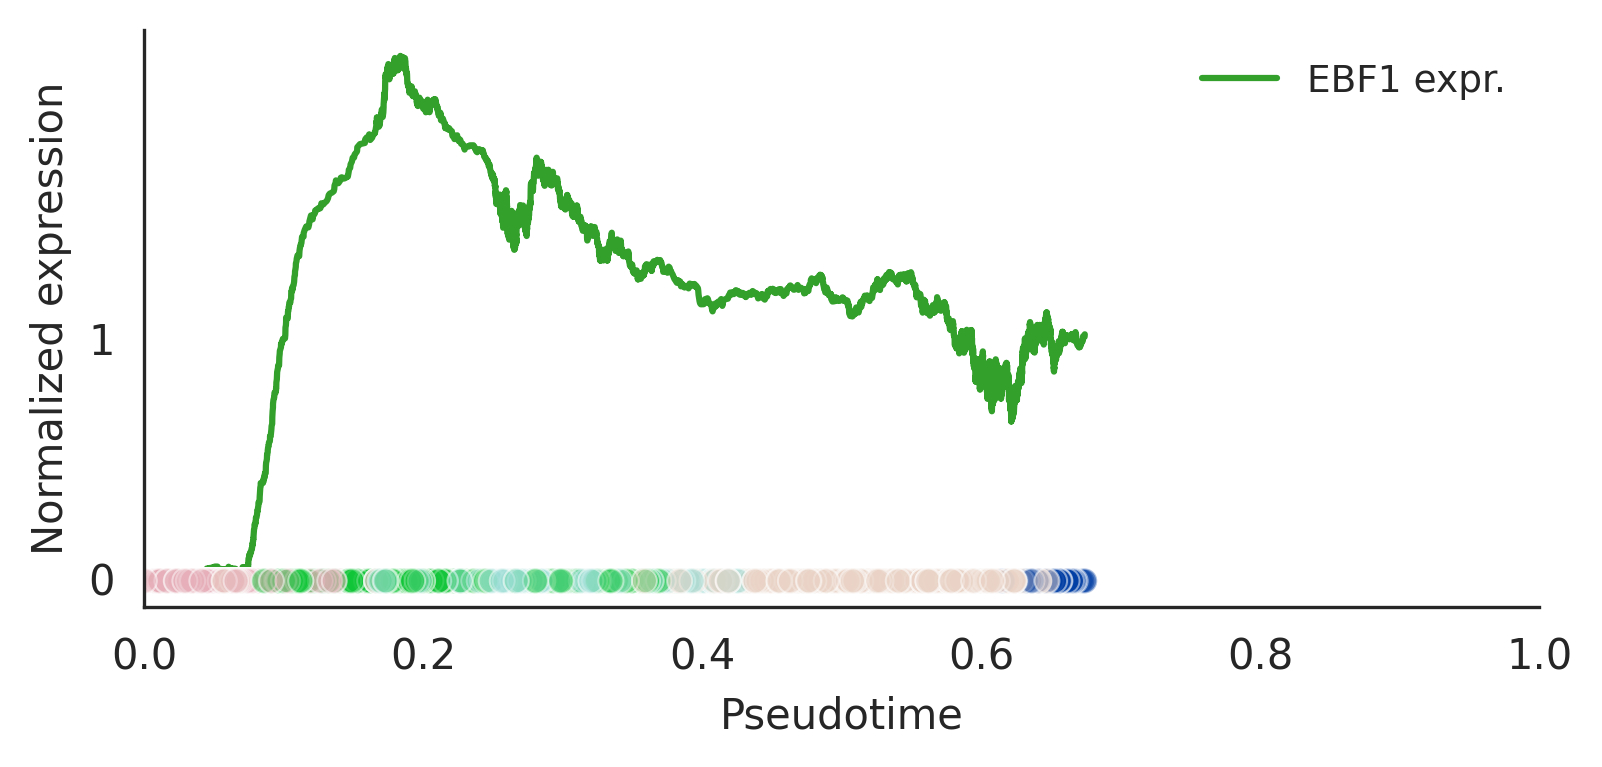

In [42]:
cmap = mpl.colormaps['Paired']

sns.set_style("white")
for i, tf in enumerate(ad_alt.keys()): 
    fig, ax_pred = plt.subplots(figsize=(6,2.5), dpi=300)
    fig2, ax_actual = plt.subplots(figsize=(6,2.5), dpi=300)

    if tf == "GATA1":
        cells = meta_lineage_cells[['Erythroblast']]
    elif tf == "EBF1":
        cells = meta_lineage_cells[['B']]

    ax_pred, _ = plot_cells_pseudotime(
        ad_alt[tf],
        cells, 
        'atac_difference', 
        layer=None, 
        title=f"{tf} motif effect on acc.", 
        ax = ax_pred, 
        color = cmap(2*i), 
        scale=True
    )
    ax_pred, _ = plot_cells_pseudotime(
        ad_alt[tf],
        cells, 
        'rna_difference', 
        layer=None, 
        title=f"{tf} motif effect on expr. ", 
        ax=ax_pred, 
        color = cmap(2*i+1), 
        scale=True,
        plot_cells=(i==(len(ad_alt.keys())-1))
    )
    
    ax_actual, _ = plot_cells_pseudotime(
        adata[:,adata.var.feature_types == 'GEX'],
        cells, 
        tf,
        layer=None, 
        title=f"{tf} expr.", 
        ax=ax_actual, 
        color = cmap(2*i+1), 
        scale=True,
        plot_cells=(i==(len(ad_alt.keys())-1))
    )
    sns.despine(fig)
    ax_pred.legend(loc='upper right', frameon=False, fontsize=9)
    ax_pred.set_xlim(0,1)
    ax_pred.set_xlabel("")
    ax_pred.set_ylabel("Normalized TF activity")
    ax_pred.set_yticks([0,1])
    ax_pred.set_xticks([])
    fig.set_dpi
    fig.savefig(f'figures/Figure3/{tf}_TFactivity.png', dpi=300, bbox_inches='tight')
    
    sns.despine(fig2)
    ax_actual.legend(loc='upper right', frameon=False, fontsize=9)
    ax_actual.set_xlim(0,1)
    ax_actual.set_xlabel("Pseudotime")
    ax_actual.set_ylabel("Normalized expression")
    ax_actual.set_yticks([0,1])
    fig2.savefig(f'figures/Figure3/{tf}_expr.png', dpi=300, bbox_inches='tight')

# Get motif clusters

In [13]:
cells_to_run = dict()
for ct in  adata.obs.l2_cell_type.unique():
    cells_to_run[ct] = adata.obs.loc[adata.obs.l2_cell_type == ct][["l2_cell_type"]].dropna()

In [14]:
#TODO change path
if not os.path.exists(os.path.join(data_path, 'eval/all_effects.pickle')):
    deletion_per_cell_type = dict()
    alts =  [x for x in glob.glob(f'{motif_path}*multiome_fixed.h5ad') if 'ref_multiome' not in x and 'atac' not in x]
    ad_alts = dict()
    ad_ref_whole = sc.read(os.path.join(motif_path, 'ref_multiome_fixed.h5ad'))
    
    for i, alt in enumerate(alts):
        name = alt.split('alt_')[1].split('_multiome')[0].replace("H12CORE.", "")
        print (name, alt)
        temp_whole = sc.read(alt)
        deletion_per_cell_type = dict()
    
        for j, (ct, x) in enumerate(cells_to_run.items()):
            ad_ref = ad_ref_whole[x.index]
            temp = temp_whole[x.index]
            deletion_per_cell_type[ct] = dict()
            deletion_per_cell_type[ct]['atac_difference'] = np.log2(np.sum(temp.layers['atac']+1, axis=0)) - np.log2(np.sum(ad_ref.layers['atac']+1, axis = 0))
            deletion_per_cell_type[ct]['rna_difference'] = np.log2(np.sum(temp.X+1, axis=0)) - np.log2(np.sum(ad_ref.X+1, axis = 0))
        del temp_whole
        gc.collect()
        ad_alts[name] = deletion_per_cell_type
    
    all_effects = pd.concat({
            k: pd.DataFrame.from_dict(v, 'index') for k, v in ad_alts.items()
        }, 
        axis=0)
    
else:
    with open(os.path.join(data_path, 'eval/all_effects.pickle'), 'rb') as file:
        all_effects = pickle.load(file)
    ad_ref_whole = sc.read(os.path.join(motif_path, 'ref_multiome_fixed.h5ad'))

### Plot GATA, TAL and KLF1 effects on Ery lineage

In [15]:
subset_df = pd.DataFrame(np.vstack(all_effects['rna_difference'].values), columns =ad_ref_whole.var_names, index=all_effects.index)
subset_df= subset_df.loc[["GATA1.1.PSM.A", "TAL1.1.P.B", "KLF1.0.P.B"]].swaplevel(1,0).loc[['MK/E prog',  "Proerythroblast", "Erythroblast"]]

In [16]:
subset_df = subset_df.reset_index()

row_colors = subset_df['level_0'].map(
    dict(zip(adata.obs.l2_cell_type.cat.categories, adata.uns['l2_cell_type_colors']))).to_numpy()
subset_df = subset_df.set_index(["level_0", "level_1"])

In [17]:
subset_df = subset_df.loc[:,~(subset_df.sum() == 0)]
subset_df

column_4                           AFF3     BACH2     BANK1      CD74  \
level_0         level_1                                                 
MK/E prog       GATA1.1.PSM.A -0.002084  0.014479 -0.001746 -0.021664   
                TAL1.1.P.B     0.003249  0.010145 -0.001948 -0.134639   
                KLF1.0.P.B     0.029549 -0.004234 -0.000374 -0.190263   
Proerythroblast GATA1.1.PSM.A -0.001060  0.006380 -0.000692 -0.006099   
                TAL1.1.P.B     0.000841  0.002208 -0.000905 -0.080052   
                KLF1.0.P.B     0.016121 -0.003017 -0.000063 -0.113584   
Erythroblast    GATA1.1.PSM.A -0.000190  0.002143 -0.000310 -0.005887   
                TAL1.1.P.B    -0.000082  0.000541 -0.000688 -0.057333   
                KLF1.0.P.B     0.005126 -0.004931 -0.000216 -0.076256   

column_4                           EBF1   RALGPS2      IGHM      PAX5  \
level_0         level_1                                                 
MK/E prog       GATA1.1.PSM.A -0.015431 -0.005124 -0.052877 -0.002728   
                TAL1.1.P.B    -0.031467  0.004098 -0.077820  0.003407   
                KLF1.0.P.B    -0.043365  0.088893  0.012330 -0.005337   
Proerythroblast GATA1.1.PSM.A -0.008560 -0.005934 -0.022090 -0.001920   
                TAL1.1.P.B    -0.017529 -0.009110 -0.037098  0.001184   
                KLF1.0.P.B    -0.021609  0.092655  0.012480 -0.002913   
Erythroblast    GATA1.1.PSM.A -0.004202 -0.004079  0.002516 -0.001246   
                TAL1.1.P.B    -0.008452 -0.005734 -0.010606  0.000594   
                KLF1.0.P.B    -0.009709  0.046556  0.012497 -0.002115   

column_4                         ZCCHC7     FCRL1  ...    ZNF618      LAT2  \
level_0         level_1                            ...                       
MK/E prog       GATA1.1.PSM.A -0.069940 -0.001789  ... -0.012082  0.004012   
                TAL1.1.P.B    -0.045793 -0.002684  ...  0.000917 -0.023632   
                KLF1.0.P.B     0.060852 -0.002917  ...  0.010920 -0.012305   
Proerythroblast GATA1.1.PSM.A -0.100859 -0.000790  ... -0.005545  0.002911   
                TAL1.1.P.B    -0.047885 -0.001305  ...  0.000664 -0.020323   
                KLF1.0.P.B     0.079899 -0.001479  ...  0.027738 -0.009357   
Erythroblast    GATA1.1.PSM.A -0.081820 -0.000436  ... -0.001322  0.001748   
                TAL1.1.P.B    -0.035942 -0.000911  ... -0.000729 -0.012911   
                KLF1.0.P.B     0.045930 -0.000959  ...  0.018914 -0.006502   

column_4                          CXXC5      GEN1    GOLIM4     RBBP8  \
level_0         level_1                                                 
MK/E prog       GATA1.1.PSM.A  0.005265 -0.006471 -0.005877 -0.003309   
                TAL1.1.P.B     0.016116  0.009517 -0.017389 -0.017153   
                KLF1.0.P.B    -0.006191 -0.038148  0.060470 -0.038588   
Proerythroblast GATA1.1.PSM.A  0.005569 -0.014968 -0.020907 -0.002779   
                TAL1.1.P.B     0.019063  0.015811 -0.017118 -0.035494   
                KLF1.0.P.B     0.003125 -0.127224  0.053652 -0.037867   
Erythroblast    GATA1.1.PSM.A  0.004113 -0.017864 -0.017538 -0.000511   
                TAL1.1.P.B     0.014832  0.015203 -0.012845 -0.037116   
                KLF1.0.P.B    -0.000980 -0.151012  0.027609 -0.018846   

column_4                         SCPEP1     MYO1E      PTK2    SESTD1  
level_0         level_1                                                
MK/E prog       GATA1.1.PSM.A  0.016160 -0.005607 -0.025695 -0.002645  
                TAL1.1.P.B    -0.023604 -0.010730  0.039801  0.018910  
                KLF1.0.P.B     0.114197 -0.006707  0.006330  0.016289  
Proerythroblast GATA1.1.PSM.A  0.022660 -0.002105 -0.042249 -0.001410  
                TAL1.1.P.B    -0.055990 -0.003729  0.019058  0.016640  
                KLF1.0.P.B     0.097266 -0.001281  0.003604  0.019125  
Erythroblast    GATA1.1.PSM.A  0.023150 -0.000484 -0.026867 -0.001156  
                TAL1.1.P.B    -0.077690 -0.002133  0.005754  0.009106  
         

Text(0, 0.5, 'Var effect')

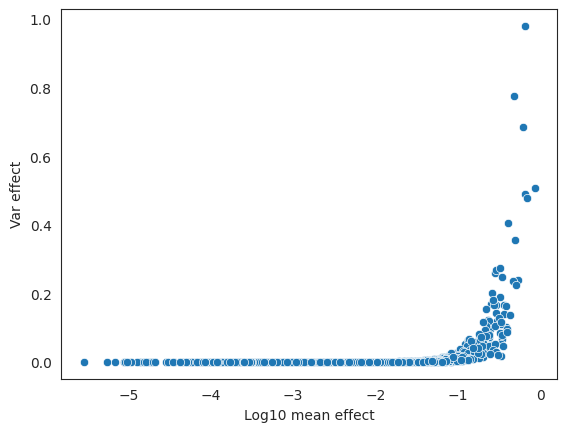

In [18]:
sns.scatterplot(x=np.log10(subset_df.abs().mean(axis=0)), y=subset_df.abs().var(axis=0) )
plt.xlabel('Log10 mean effect')
plt.ylabel('Var effect')

In [19]:
null_genes = subset_df.loc[:, (np.log10(subset_df.abs().mean(axis=0)) < -1) ].columns.tolist() #[]

In [20]:
subset_df = subset_df.drop(null_genes, axis=1)
subset_df = subset_df.sort_values('level_1')

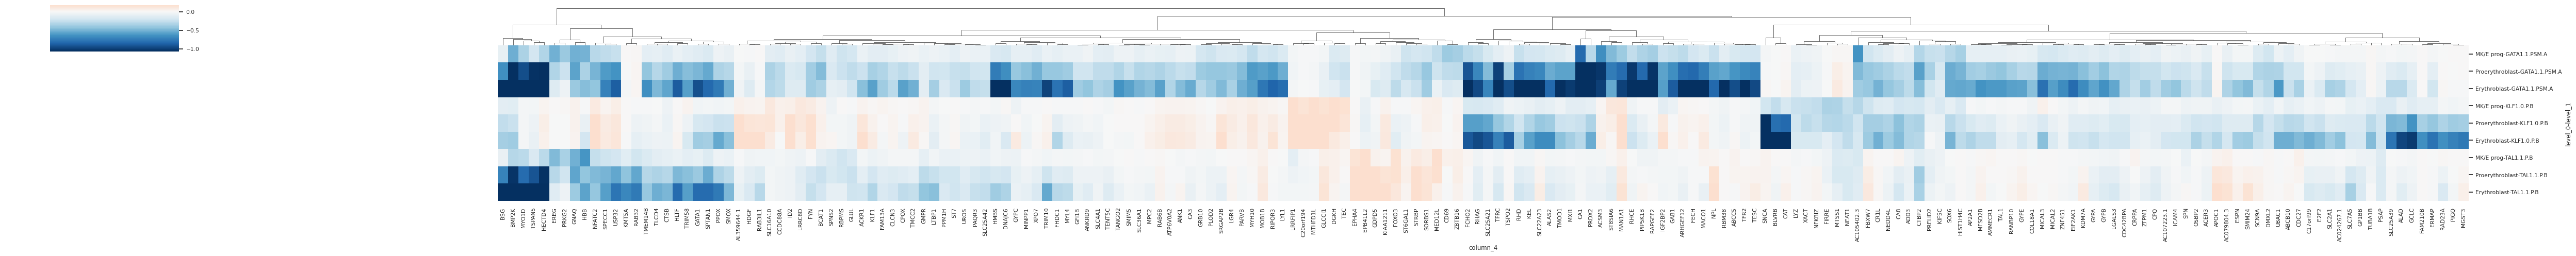

In [21]:
sns.set(font_scale=0.7)
clustergrid = sns.clustermap(
    subset_df, 
    metric = "seuclidean", 
    method = 'ward', 
    yticklabels = 1,
    xticklabels = 1, 
    row_colors=None, 
    cmap='RdBu_r', 
    center=0, 
    figsize=(50,5), 
    robust = True,
    row_cluster= False, 
    col_cluster=True,
)

In [22]:
clusters_genes = scipy.cluster.hierarchy.fcluster(clustergrid.dendrogram_col.linkage, t=9, criterion='maxclust')#scipy.cluster.hierarchy.cut_tree(ax.dendrogram_col.linkage, n_clusters=3).squeeze()

In [23]:
cluster = pd.DataFrame({'genes': subset_df.columns, 'cluster': pd.Categorical(clusters_genes)})

In [24]:
cluster_cmap = dict(
    zip(cluster.cluster.cat.categories, 
        sns.color_palette("tab20", len(cluster.cluster.cat.categories)).as_hex())
)
sns.color_palette("tab20", len(cluster.cluster.cat.categories))
cluster['color'] = cluster.cluster.map(cluster_cmap)

In [25]:
enr_up=gp.enrichr(subset_df.columns.tolist(),
                        gene_sets='GO_Biological_Process_2021',
                        outdir=None, organism='human',
                  background=3000
                 )

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


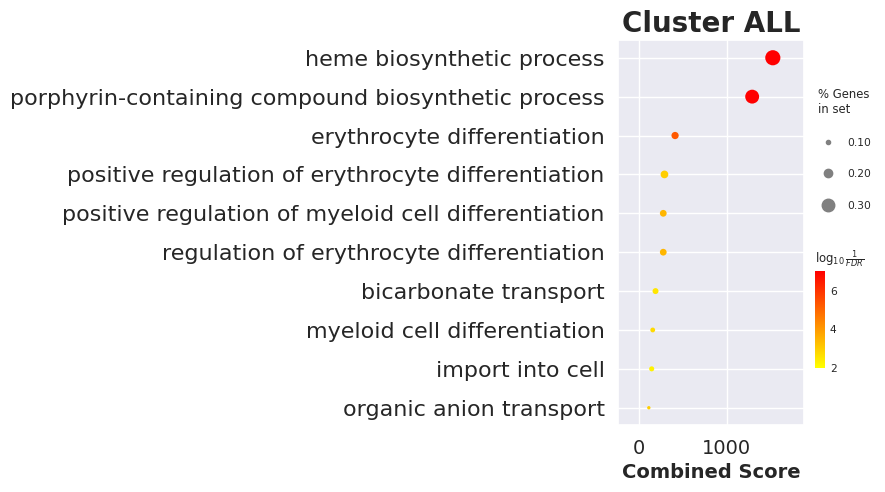

In [26]:
if (enr_up.results['Adjusted P-value']< 0.05).sum() > 0:
    enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]
    enr_up.res2d = enr_up.res2d.loc[enr_up.res2d.Overlap.str.split('/').str[0].astype(int) > 3]
    enr_up.res2d = enr_up.res2d.loc[enr_up.res2d['Adjusted P-value']< 0.05]
    # dotplot
    gp.dotplot(enr_up.res2d, figsize=(3,5), title=f"Cluster ALL", cmap = plt.cm.autumn_r)
    plt.show()

In [27]:
enr_up.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,heme biosynthetic process,8/22,1.775763e-11,2.534014e-08,0,0,61.472050,1521.691770,ALAD;ALAS2;ABCB10;FECH;UROS;HMBS;CPOX;PPOX
1,GO_Biological_Process_2021,porphyrin-containing compound biosynthetic pro...,8/24,4.017834e-11,2.866724e-08,0,0,53.782609,1287.431582,ALAD;ALAS2;ABCB10;FECH;UROS;HMBS;CPOX;PPOX
2,GO_Biological_Process_2021,erythrocyte differentiation,8/46,1.190263e-08,5.661686e-06,0,0,22.620137,412.738474,ALAS2;TSPO2;ABCB10;TAL1;ID2;GATA1;ZFPM1;KLF1
3,GO_Biological_Process_2021,regulation of erythrocyte differentiation,6/37,1.313594e-06,3.748998e-04,0,0,20.579605,278.704304,FAM210B;ABCB10;TAL1;FOXO3;GATA1;ZFPM1
4,GO_Biological_Process_2021,positive regulation of myeloid cell differenti...,6/37,1.313594e-06,3.748998e-04,0,0,20.579605,278.704304,FAM210B;ABCB10;TAL1;TESC;FOXO3;GATA1
5,GO_Biological_Process_2021,organic anion transport,8/99,5.062296e-06,1.072739e-03,0,0,9.420449,114.870039,CA1;CA3;ABCC5;HBB;LRRC8D;SLC4A1;RHAG;SLC25A42
6,GO_Biological_Process_2021,positive regulation of erythrocyte differentia...,5/27,5.262210e-06,1.072739e-03,0,0,24.047156,292.292209,FAM210B;ABCB10;TAL1;FOXO3;GATA1
7,GO_Biological_Process_2021,myeloid cell differentiation,6/52,1.020797e-05,1.820847e-03,0,0,13.858345,159.264838,ALAS2;TAL1;ZBTB16;ZFPM1;GATA1;KLF1
8,GO_Biological_Process_2021,bicarbonate transport,5/35,1.988276e-05,3.152522e-03,0,0,17.627451,190.828746,CA1;CA3;HBB;SLC4A1;RHAG
10,GO_Biological_Process_2021,import into cell,5/41,4.380649e-05,5.598083e-03,0,0,14.685086,147.375540,SLC36A1;SLC7A5;TSPO2;LRRC8D;GLUL


In [28]:
genes = []
for x in enr_up.res2d.Genes:
    genes.extend(x.split(';'))

In [29]:
genes = set(genes)

In [30]:
row_colors = [subset_df.index.get_level_values(0).map(ct_colors).to_list(),  
              subset_df.index.get_level_values(1).map({'GATA1.1.PSM.A':'#1f78b4', 'KLF1.0.P.B': '#33a02c', 'TAL1.1.P.B': '#EF9C16'}).to_list()]

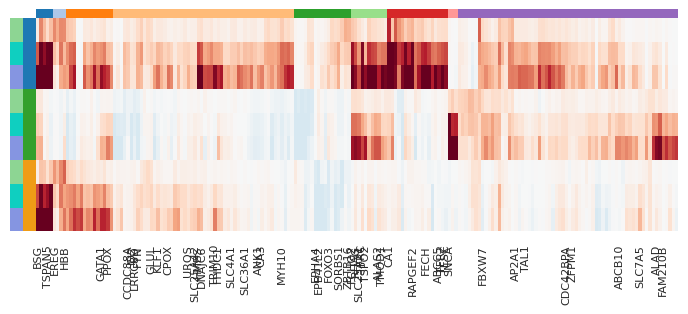

In [31]:
sns.set(font_scale=0.7)
clustergrid = sns.clustermap(
    subset_df, 
    metric = "seuclidean", 
    method = 'ward', 
    yticklabels = 1,
    xticklabels = 1, 
    cmap='RdBu', 
    center=0, 
    figsize=(11,4), 
    robust = True,
    row_cluster= False, 
    col_cluster=True,
    col_colors=cluster['color'].tolist(),
    row_colors=row_colors
)
ax_row_colors = clustergrid.ax_row_colors
box = ax_row_colors.get_position()
box_heatmap = clustergrid.ax_heatmap.get_position()
ax_row_colors.set_position([box_heatmap.min[0]-box.width*0.5, box.y0, box.width*0.5, box.height])


clustergrid.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
clustergrid.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
clustergrid.ax_cbar.set_visible(False)

[tick.set_fontsize(8) if tick._text in subset_df.columns[subset_df.columns.isin(genes)].tolist() + ['TRIM10'] else tick.set_visible(0) for tick in clustergrid.ax_heatmap.get_xmajorticklabels() ]
clustergrid.ax_heatmap.set_xlabel("")
clustergrid.ax_heatmap.set_ylabel("")
clustergrid.ax_heatmap.set_yticks([])
clustergrid.ax_heatmap.set_yticklabels([])
plt.savefig('figures/Figure3/target_gene_heatmap.svg')


In [32]:
colormap = clustergrid
colormap.ax_row_dendrogram.remove()
colormap.ax_col_dendrogram.remove()
colormap.ax_cbar.set_visible(True)
colormap.ax_heatmap.remove()
colormap.savefig('../figures/figures/Figure3/heatmap_target_gene_colormap.svg', dpi=300, bbox_inches ='tight')

In [33]:
cluster.genes[cluster.cluster == 2]

39      EREG
82      GNAQ
85       HBB
161    PRKG2
Name: genes, dtype: object

In [34]:
# Enricr API
results = []
for cluster_i in sorted(cluster.cluster.unique()):
    enr_up = gp.enrichr(cluster.genes[cluster.cluster == cluster_i],
                        gene_sets='GO_Biological_Process_2021',
                        outdir=None)
    if (enr_up.res2d['Adjusted P-value']< 0.05).sum() > 0:
        enr_up.res2d['Term_new'] = enr_up.res2d.Term.str.split(" \(GO").str[0]
        enr_up.res2d = enr_up.res2d.loc[enr_up.res2d['Adjusted P-value']< 0.05]
        enr_up.res2d = enr_up.res2d.loc[enr_up.res2d.Overlap.str.split('/').str[0].astype(int) > 1]
        enr_up.res2d['Cluster'] = cluster_i
        results.append(enr_up.res2d.sort_values('Adjusted P-value'))

In [35]:
results = pd.concat(results)

# TF scores

In [36]:
if False:
    all_tfs = [x for x in glob.glob(f'{motif_path}*multiome_fixed.h5ad') if 'ref_multiome' not in x and 'atac' not in x]
    
    ad_alt = dict()
    ad_ref = sc.read(os.path.join('ref_multiome_fixed.h5ad'))
    ad_ref = ad_ref[adata.obs_names]
    median_sf_rna=np.median(ad_ref.X.sum(axis=1))
    median_sf_atac=np.median(ad_ref.layers['atac'].sum(axis=1))
    sc.pp.normalize_total(ad_ref, target_sum=median_sf_rna, key_added='size_factor_rna')
    
    norm_factor_rna = ad_ref.obs['size_factor_rna'].values[:, None]
    ad_alt_df = dict()
    for i, tf_path in tqdm.tqdm(enumerate(all_tfs)):
        ad_alt = sc.read(tf_path)
        motif_name = os.path.basename(tf_path).split('alt_')[1].split('_multiome_fixed.h5ad')[0]
        name = tf_path.split('alt_')[1].split('.')[0]
        ad_alt = ad_alt[adata.obs_names]
    
        ad_alt.X = ad_alt.X/norm_factor_rna * median_sf_rna
    
        motif_rna = (np.log2(ad_ref.X+1) - np.log2(ad_alt.X+1)).mean(axis=1).squeeze()
        ad_alt_df[name] = dict()
        ad_alt_df[name]['rna_difference'] = motif_rna
        gc.collect()
    
    results = pd.DataFrame(ad_alt_df).T
    results = results.reset_index().rename({"index" : "TF"}, axis = 1)
    results.to_parquet("TF_motif_effect_scores.pq")
else:
    results = pd.read_parquet("TF_motif_effect_scores.pq")

In [37]:
ad_tf = sc.AnnData(np.stack(results['rna_difference']).T, obs=adata.obs, var=results[['TF']].set_index('TF'))

In [38]:
results = results.explode('rna_difference')

In [39]:
results['celltype'] = adata.obs.l2_cell_type.tolist() * len(results.TF.unique())

### Plot all effects

In [45]:
def normalize_iqr(series, q=[0.1, 0.9]):
    bounds = series.abs().quantile(q).values
    iqr = bounds[1] #- bounds[0]
    normalized_data = (series.abs())/iqr
    return normalized_data * np.sign(series)

In [46]:
sns_df = results.groupby(['celltype', 'TF']).rna_difference.mean().reset_index()

In [47]:
sns_df = sns_df.pivot(index='celltype', columns='TF').astype(float)

In [48]:
sns_df.columns = sns_df.columns.droplevel(0)

In [49]:
sns_df = sns_df.rename({"COE1": "EBF1"}, axis=1)

In [50]:
sns_df = sns_df.apply(normalize_iqr, axis=0)

Text(1463.375, 0.5, '')

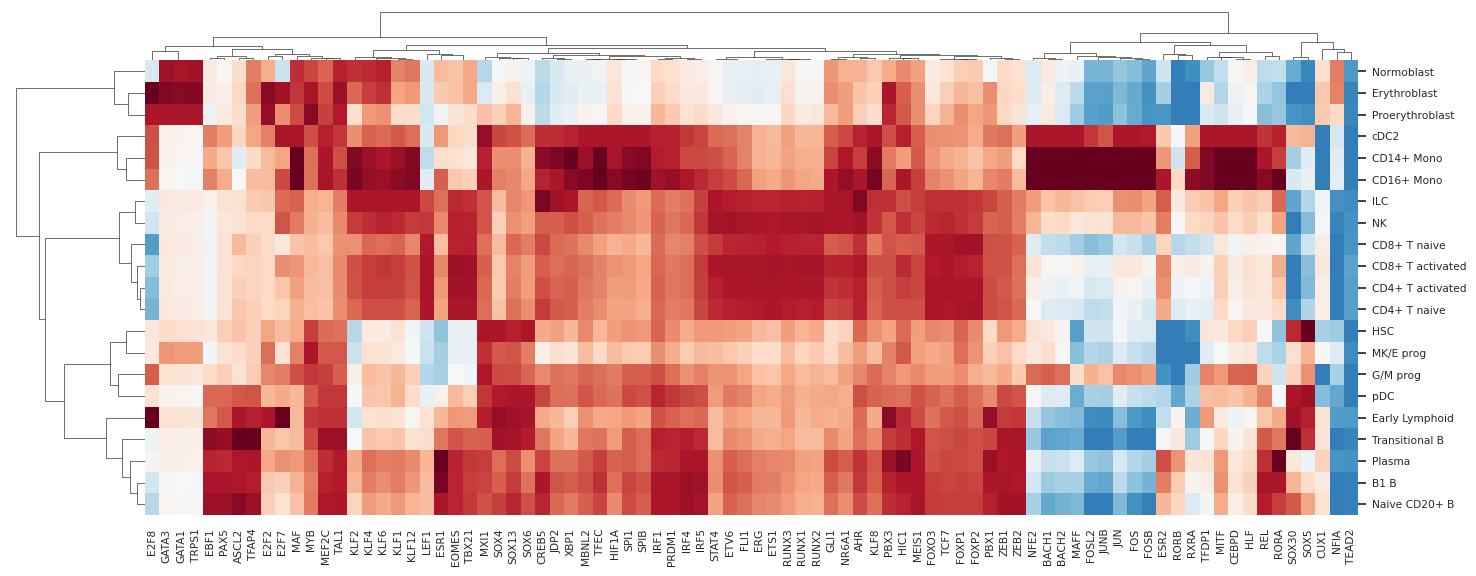

In [51]:
clustergrid = sns.clustermap(
    sns_df,
     metric = "seuclidean", 
    method = 'ward', 
    yticklabels = 1,
    xticklabels = 1, 
    cmap='RdBu_r', 
    center=0, 
    vmin=-0.86,
    figsize=(15,6), 
    robust = True,
    row_cluster= True, 
    col_cluster=True,
    dendrogram_ratio=(0.1, .1)
)
clustergrid.ax_cbar.set_visible(False)
clustergrid.ax_heatmap.set_xlabel("")
clustergrid.ax_heatmap.set_ylabel("")
#plt.savefig('../figures/figures/Figure3/heatmap_all_motif_effects.png', dpi=300, bbox_inches ='tight')

In [52]:
ad_tf.var = ad_tf.var.rename({"COE1": "EBF1"})

In [53]:
tf_list = pd.read_table("tf_masterlist.tsv")
tf_list= tf_list.loc[tf_list['curated:uniprot_id'].str.contains("HUMAN")]
tf_list['uniprot_id'] = tf_list['curated:uniprot_id'].str.split('_').str[0]

In [54]:
sns_df = results.merge(tf_list, left_on="TF", right_on = "uniprot_id")

In [55]:
grouped = sns_df.groupby("tfclass:family")['TF'].apply(lambda x: ','.join(np.unique(x))).reset_index()

In [56]:
grouped = grouped.replace({"COE1": "EBF1"})

In [57]:
sns_df = sns_df.groupby(['celltype', "tfclass:family"]).rna_difference.mean().reset_index()

In [58]:
sns_df = sns_df.pivot(index='celltype', columns="tfclass:family").astype(float)

In [59]:
sns_df.columns = sns_df.columns.droplevel(0)

In [60]:
sns_df = sns_df.apply(normalize_iqr, axis=0)

In [61]:
sns_df.columns = sns_df.columns.map(grouped.set_index("tfclass:family").to_dict()['TF']).astype(str)

In [62]:
colors_equal = dict()
for lineage in adata.obs.l1_cell_type.unique():
    l2_cell_types = adata.obs.query("l1_cell_type == @lineage").l2_cell_type.unique().tolist()
    
    if " B" in l2_cell_types[0] or 'Early' in l2_cell_types[0] or 'Plasma' in l2_cell_types[0]:
        setter = '#023fa5'
    elif "T " in l2_cell_types[0] or 'NK' in l2_cell_types[0]:
        setter = '#c5dbc6'
    elif "Mono" in l2_cell_types[0]:
        setter = '#8e063b'
    elif 'Erythro' in l2_cell_types[0]:
        setter = '#8595e1'
    else:
        setter = '#808080'
    for l2 in l2_cell_types:
        colors_equal[l2] = setter


In [63]:
colors_equal['HSC'] = '#e4aeb8'
colors_equal['G/M prog'] = '#e4aeb8'
colors_equal['MK/E prog'] = '#e4aeb8'
colors_equal['ILC'] = '#c5dbc6'


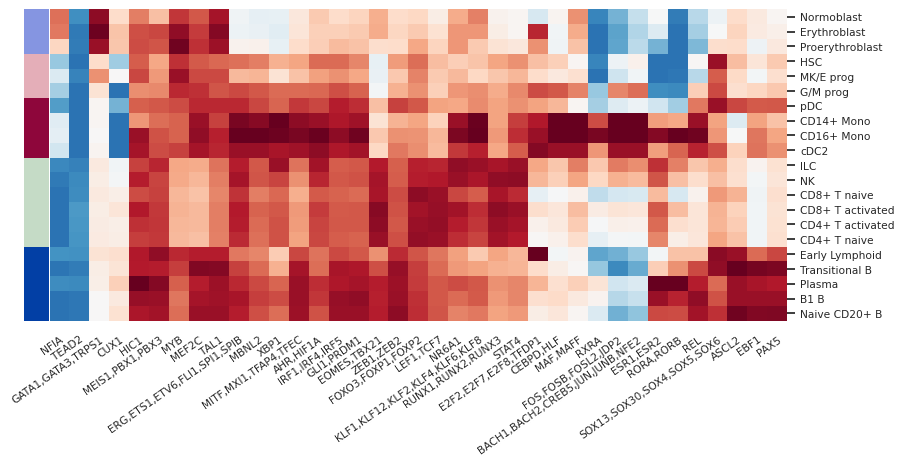

In [64]:
clustergrid = sns.clustermap(
    sns_df,
     metric = "seuclidean", 
    method = 'ward', 
    yticklabels = 1,
    xticklabels = 1, 
    cmap='RdBu_r', 
    center=0, 
    vmin=-0.86,
    figsize=(10,6), 
    robust = True,
    row_cluster= True, 
    col_cluster=True,
    dendrogram_ratio=(0.1, .1),
    row_colors=[colors_equal[x] for x in sns_df.index.tolist()]
)
clustergrid.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
clustergrid.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
clustergrid.ax_cbar.set_visible(False)

clustergrid.ax_heatmap.set_xlabel("")
clustergrid.ax_heatmap.set_ylabel("")
plt.setp(clustergrid.ax_heatmap.get_xticklabels(), rotation=35, ha="right",
         rotation_mode="anchor");
plt.gcf().savefig('figures/Figure3/heatmap_tf_class.svg', dpi=300, bbox_inches='tight')

In [65]:
colormap = clustergrid
colormap.ax_row_dendrogram.remove()
colormap.ax_col_dendrogram.remove()
colormap.ax_cbar.set_visible(True)
colormap.ax_heatmap.remove()
colormap.savefig('../figures/figures/Figure3/heatmap_tf_class_colormap.svg', dpi=300, bbox_inches ='tight')